In [2]:
import matplotlib.pyplot as plt
import json
import colorcet
import pandas
import seaborn as sns
import xarray
import numpy as np
from pyeosim.datasets import DATA_PATHS
from pyeosim.postprocess import CmosReflectance
from pyeosim.spectral import Sentinel2VNIR, TreeView_2, SuperDove
from pyeosim.sensor import TeledyneCMOS
from pyeosim.atmosphere import Test6S, LUT_from_file
from pyeosim.plot import rgb

In [3]:
# load and preprocess imagery
fpath = DATA_PATHS['TEST_HSI_LARGE']
im = xarray.open_dataset(fpath).Reflectance
rgb_image = rgb(im.isel(band=[70,40,20]), return_array=True)
im = im.swap_dims({'band':'wavelength'})
im_ref = im.sel(wavelength=slice(400,898)).astype(float)/10000

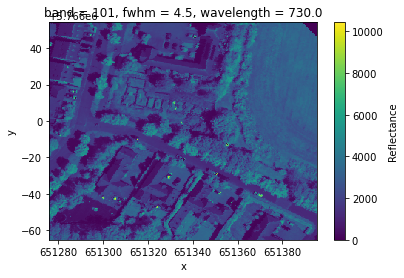

In [4]:
im.isel(wavelength=100).plot()

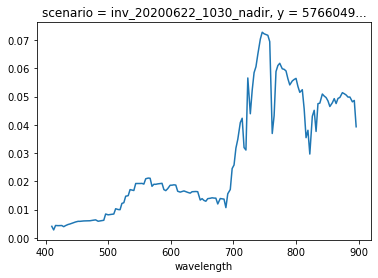

In [5]:
atmos = LUT_from_file('atmospheres/atmospheres_2/', {
    'view_z': 0,
    'view_a': 0
})
# atmos = Test6S()
# # generate Top of Atmosphere images
TOA = atmos.transform(im_ref).compute()
TOA_ref = atmos.transform(xarray.ones_like(im_ref))
TOA.isel(scenario=0).sel(x=651380, y=5766049, method='nearest').plot()

In [6]:
tv2_spectral = TreeView_2()

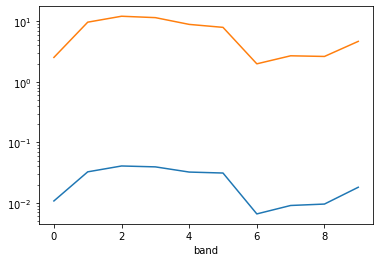

In [7]:
tv2_spectral.transform(TOA.min(['x','y', 'scenario'])).plot()
tv2_spectral.transform(TOA.max(['x','y', 'scenario'])).plot()
plt.yscale('log')

In [12]:
690 * 15

10350

In [6]:
np.sqrt(np.pi * (.25**2))

0.44311346272637897

In [23]:
(1/106000)*1e6

9.433962264150944

In [13]:
TeledyneCMOS?

Init signature:
TeledyneCMOS(
    sensor_altitude=500000.0,
    sensor_ground_speed=7000,
    ground_sample_distance=2,
    lens_diameter=0.1,
    psf_fwhm=4,
    TDI_rows=32,
    pix_per_row=8000,
    sensor_width=82.2,
    pixel_area=100,
    spectral_response=None,
    quantum_efficiency='TDI_QE_BACK',
    full_well=30000.0,
    prnu_factor=0.01,
    dark_current=570,
    dark_factor=0.01,
    offset_factor=0.001,
    ccd_vref=3.1,
    sense_node_gain=5,
    read_noise=20,
    adc_vref=0.5,
    bit_depth=14,
    store_steps=False,
)
Docstring:     
Teledyne CMOS sensor assuming a single multispectral array and perfect
optics.
Init docstring:
Parameters
----------
sensor_altitude : float
    altitude above source in metres
sensor_ground_speed : float
    relative ground speed of sensor in m/s
ground_sample_distance : float
    Ground sampling distance of sensor
lens_diameter : float
    diameter of lens in metres
psf_fwhm : float
    Point Spread Function Full-Width at Half Maximum
 

In [26]:
cmos = TeledyneCMOS(store_steps=True,
                    TDI_rows=16,
                    lens_diameter=.44,
                    pix_per_row=8196,
                    sense_node_gain=(1/106000)*1e6,
                    dark_current=570/32,
                    ccd_vref=1, adc_vref=1,
                    offset_factor=0,
                    prnu_factor=.001,
                    full_well=106000,
                    spectral_response=TreeView_2(),
                    bit_depth=12,
                   )
demo = cmos.fit_transform(TOA)
# cmos.get_params()
demo.attrs.pop('input_signal_meta')

{}

Text(0.5, 0, 'Wavelength (nm)')

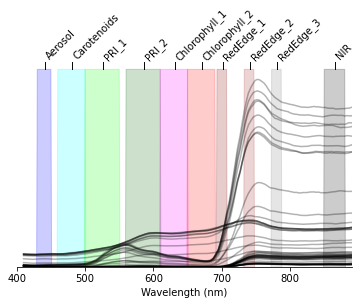

In [37]:
srf = cmos.spectral_response
ymax = .75
band_cols = ['blue', 'aqua', 'lime', 'darkgreen', 'magenta', 'red', 'darkred','brown','grey', 'k']
for n, c in zip(srf.band_names, band_cols):
#     srf.srfs[n].plot(c=c, label=n,)
    plt.fill_between(x=srf.srfs[n].wavelength, y1=srf.srfs[n].values*ymax,color=c, alpha=.2)
plt.ylim(.01,ymax*1.1)
plt.xlim(400,890)
# plt.legend()

for wlen, name in zip(srf.band_wavelengths.values(), srf.band_names):
    plt.annotate(name, (wlen,ymax*1.05), rotation=45)
    plt.annotate('I', (wlen,ymax*1), rotation=0)

im_ref.isel(y=200, x=slice(30,80)).plot(hue='x', c='k', alpha=.3, add_legend=False,)
plt.title('')
sns.despine(left=True)
plt.yticks([])
plt.ylabel('')
plt.xlim(400,890)
plt.xlabel('Wavelength (nm)')

In [ ]:
demo.isel(band=2, scenario=8).plot(cmap='inferno')

In [8]:
demo.isel(scenario=0).to_dataset(name='DN').to_netcdf('Treeview_v3_simulation_1.nc')

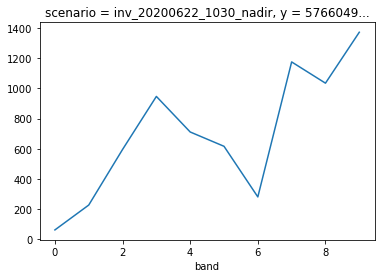

In [9]:
demo.sel(x=651380, y=5766049, method='nearest').isel(scenario=0).plot()

In [10]:
# demo.isel(scenario=0).sel(x=651380, y=5766050, method='nearest').plot()

In [11]:
json.loads(demo.attrs['TeledyneCMOS_sensor_simulation'])

{'_fitted': True,
 'sensor_altitude': 500000.0,
 'sensor_ground_speed': 7000,
 'ground_sample_distance': 2,
 'lens_diameter': 0.44,
 'psf_fwhm': 4,
 'TDI_rows': 16,
 'pix_per_row': 8196,
 'sensor_width': 82.2,
 'pixel_area': 100,
 'spectral_response': '<Not stored>',
 'quantum_efficiency': 'TDI_QE_BACK',
 'full_well': 106000,
 'prnu_factor': 0.001,
 'dark_current': 17.8125,
 'dark_factor': 0.01,
 'offset_factor': 0,
 'ccd_vref': 1,
 'sense_node_gain': 9.433962264150944,
 'read_noise': 20,
 'adc_vref': 1,
 'bit_depth': 12,
 'PRNU': '<Not stored>',
 'DSNU': '<Not stored>',
 'column_offset_FPN': '<Not stored>',
 'integration_time': 0.004571428571428572,
 'Q_E': '<Not stored>',
 '_dark_current': 285.0,
 'swath_width': 16392,
 'afov': 0.03278106414522767,
 'pix_width': 1e-05,
 'focal_length': 2.5066469330166905,
 '_sense_node_gain': 9.433962264150944e-06}

Text(0.5, 0, 'Wavelength (nm)')

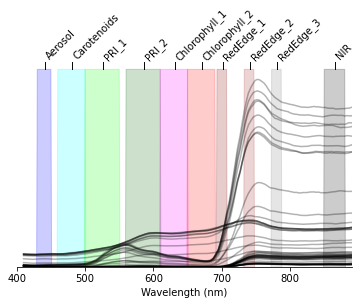

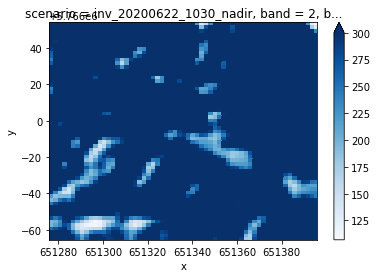

In [20]:
demo.isel(band=2, scenario=0).plot(vmax=300, cmap='Blues')

In [97]:
cmos_pipe = CmosReflectance(cmos, TOA_ref)
cmos_pipe.fit(TOA.isel(scenario=0))
BOA = cmos_pipe.transform(TOA)
# # write latex table of parameters
cmos.steps_to_latex('outputs/cmos.tex')
# # generate reference and signal arrays

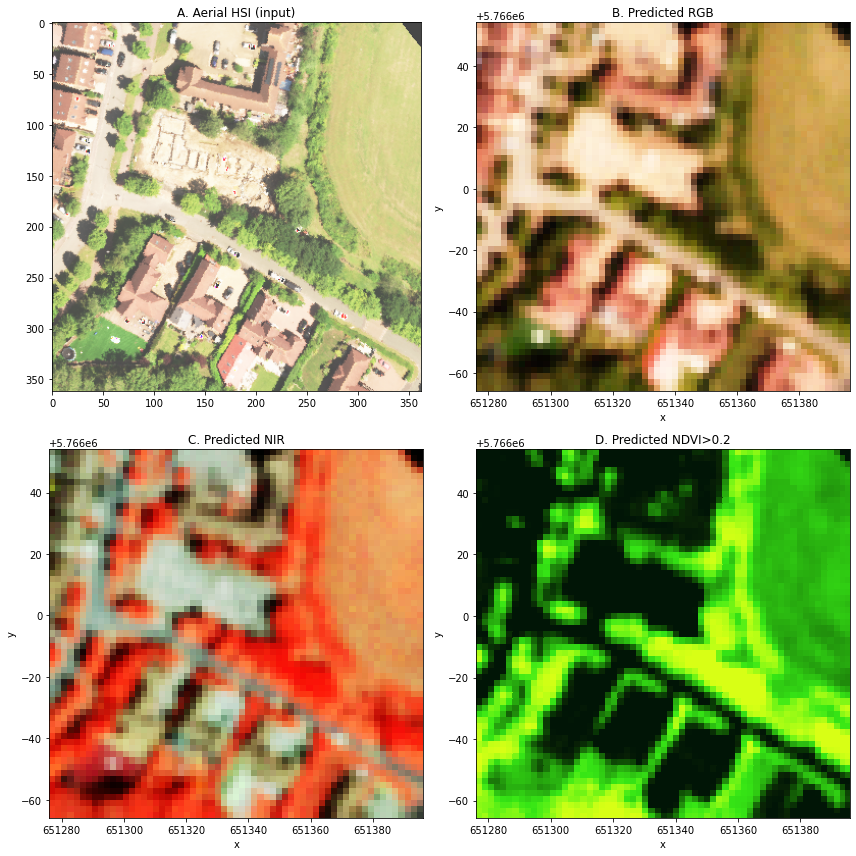

In [98]:
BOA_ = BOA.isel(scenario=1)
# BOA_ = BOA.isel(scenario=0)
# calculate some composites
bgr = BOA_.isel(band=[4,2,1])
nir = BOA_.isel(band=[9,6,3])
ndvi = ((BOA_.isel(band=9) - BOA_.isel(band=5))/(BOA_.isel(band=9) + BOA_.isel(band=5)))
# plot
fig, ax = plt.subplots(2,2, figsize=(12,12))

ax[0][0].imshow(rgb_image)
ax[0][0].set_title('A. Aerial HSI (input)')

rgb(bgr,ax=ax[0][1])
ax[0][1].set_title('B. Predicted RGB')

rgb(nir,ax=ax[1][0])
ax[1][0].set_title('C. Predicted NIR')

ndvi.plot(ax=ax[1][1], add_colorbar=False, vmin=.1, robust=True, cmap=colorcet.cm.kgy)
ax[1][1].set_title('D. Predicted NDVI>0.2')
plt.tight_layout()
plt.savefig('outputs/TreeView_example_1.png',dpi=200)

<ipython-input-77-025569af958e>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bmy"))
  cmap_kgy.set_over('green')
<ipython-input-77-025569af958e>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bmy"))
  cmap_kgy.set_under('w')


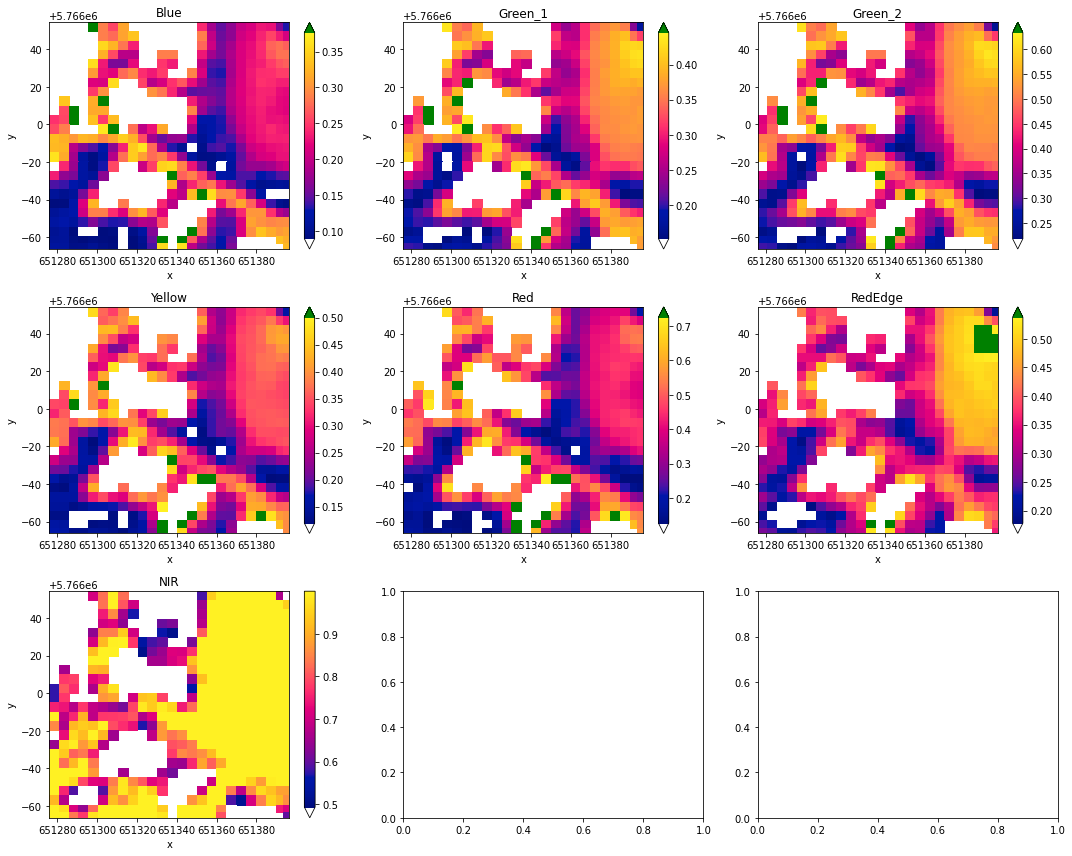

In [77]:
cmap_kgy = colorcet.cm.bmy
cmap_kgy.set_over('green')
cmap_kgy.set_under('w')
idx = 9
fig, ax = plt.subplots(3,3, figsize=(15,12))
ax = np.ravel(ax)
for i in range(1,8):
    BOA_.where(ndvi>0).isel(band=i).plot(cmap=cmap_kgy, robust=True, ax=ax[i-1], )
    ax[i-1].set_title('{}'.format(BOA_.band_name[i].values))
plt.tight_layout()
# plt.savefig('outputs/TreeView_example_1_plant.png',dpi=200)

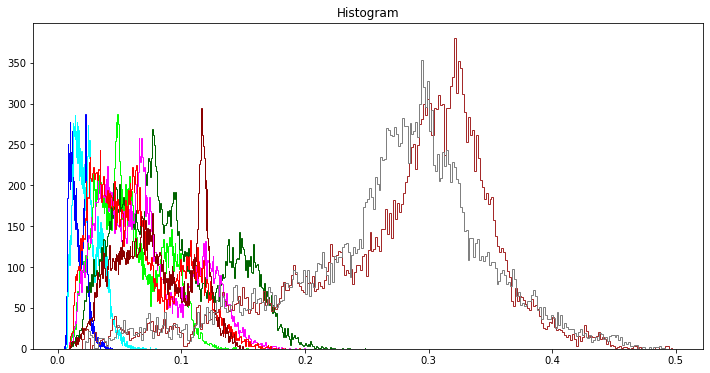

In [34]:
plt.figure(figsize=(12,6))
for i in range(9):
    BOA.isel(band=i).where(ndvi>.2).plot.hist(bins=300,histtype='step', color=band_cols[i])